# Assignment 2 - Melody Generator (of which Rhythm is part)
### Mariella Daghfal, Kaede Johnson, Shayan Khajehnouri, & Tahel Singer

In [1]:
# For TA: 

#  ctrl+f C:/Users/HP/ to change filepaths where necessary

# xml set of polska files required (ctrl + f xml_file_location). xml set from zeng's github.

# requirements.txt on github repo: https://github.com/kaedejohnson/DH401-A1-RHYTHMGEN

# cell 4 must be run to do anything with the polska corpus - it isn't loaded in later on

# most stuff is in this file. some visualizations in 

# TO SKIP TO GENERATION: ctrl+f 'Generation' (look for markdown. first is random, then bigrams)
#                      bigrams is our model. it's set up to create and spit out 5 for you, after which you create bigrams_final.pkl in the next block.
# TO SKIP TO DISTANCE CALCULATIONS: ctrl+f 'Adapted from Score Generator' (look for markdown) 
#                      need bigrams_final.pkl, randoms_final.pkl in lists_for_generation on github. ALSO NEED to run cell 4 (import xml polska)
#                      run next two cells to generate
#                      then ctrl+f 'compare corpuses' for actual distance calculation (output already on github in distance_calculations)
# have FUN


In [84]:
## Dependencies
from music21 import *
from music21 import note
from tqdm import *
import pandas as pd
import numpy as np
import collections
import pickle
import math
import os
# Many important functions in helpers.py.
# Sequestered them only to the make the Jupyter notebook readable.
from helpers import *

In [3]:
# Setup environment
# # to be safe i personally created venv with anaconda terminal.
# conda create -n "digital_musicology" python=3.8
# conda activate digital_musicology
# conda install pip
 
# Setup music21
## for viewing score, download and install finale note pad at https://store.makemusic.com/Downloads/Default.aspx?id=538&_ga=2.3616692.58482559.1678537005-1850486829.1678537005 and then run:
# configure.run()

## I don't know if it's because I screwed up something during initial setup but this is what I had to do to get music showing:
# environment.set('musescoreDirectPNGPath', 'C:\\Program Files (x86)\\Finale NotePad 2012\\Finale NotePad.exe')

# Bach score from package
# s = corpus.parse('bach/bwv65.2.xml')

# Print music12 object to show it worked
# s.show('text')

# image version (ideally this is inline but i can't get that working; for me it pulls open finale note pad with the sheet music in a separate window)
# s.show()

In [ ]:
## Load scores into corpus
# Be sure to modify folder path below

# CHANGE FOLDER BELOW TO LOCATION OF XML FILES. Download xml folders from https://github.com/DCMLab/music-generation-challenge-2021/tree/main/data
xml_file_location = 'C:/Users/HP/anaconda3/envs/digital_musicology/xml/'

# Argument defaults to False as of 20230410
slangpolska_scores = import_slangpolskas(xml_file_location, keepScoresWithChords=True)

## Below is the investigation that led to scores with chords in the first 8 measures being removed above.
## Comment in here and relevant exclusion in helpers.py to see numbers
# Investigating presence of chords
#chord = 0
#total = 0
#s_w_chord = 0
#chords = []
#for i, score in enumerate(slangpolska_scores):
#    score_counted = 0
#    for i in slangpolska_scores[score].recurse().notes:
#        if i.measureNumber > 8:
#            break
#        try:
#            chords.append(i.pitchedCommonName)
#            chord += 1
#            total += 1
#            if score_counted == 0:
#                s_w_chord += 1
#                score_counted = 1
#        except:
#            total += 1
#print("Across the first 8 measures of all scores, " + str(chord) + " chords out of " + str(total) + " notes and chords.")
#print(str(s_w_chord) + " scores with chords in the first 8 measures")
#from collections import Counter
#Counter(chords)
# Less than 1% of all events in the first 8 measures are chords. Ignoring.


In [5]:
## Investigating one score to get familiar with music21
## Comment in to see basic structure
#sample_score = slangpolska_scores['_1814_698087.xml']
#print('music21 object for imported score is called ' + str(type(sample_score)))
#print('sample score key is ' + str(sample_score.analyze('key')))
#print('The first time signature object is ' + sample_score.recurse().getElementsByClass(meter.TimeSignature)[0].ratioString)
#print('There is (are) ' + str(len(sample_score.recurse().getElementsByClass(meter.TimeSignature))) + ' time signature object(s)')
#print('Measure 6 does not have a time signature object: ' + str(sample_score.measure(6).timeSignature is None))
#print('Recall the sample score is in time ' + sample_score.recurse().getElementsByClass(meter.TimeSignature)[0].ratioString)
#curr_measure = 0
#for i in sample_score.recurse().notes:
#    if i.measureNumber != curr_measure:
#        curr_measure = i.measureNumber
#        print("Measure " + str(curr_measure))
#    print('Beat: ' + str(i.beat) + ', Duration: ' + str(i.duration.quarterLength) + ', Pitch: ' + str(i.name) + ', Accents: ' + str(i.articulations))
#print('Music21 object print:')
#sample_score.show('text')

In [3]:
# Investigating accent share of notes - conclusion: precious few, can ignore for these assignments
from collections import Counter
total_note_count = 0
total_accents = 0
total_scores_w_accents = 0
articulations = []
for i, score in enumerate(slangpolska_scores):
    fresh_score = 1
    for note in slangpolska_scores[score].recurse().notesAndRests:
        total_note_count += 1
        if len(note.articulations) > 0:
            total_accents += len(note.articulations)
            articulations.append(note.articulations)
            if fresh_score == 1:
                total_scores_w_accents += 1
                fresh_score = 0
flat_articulations = [artic.name for sublist in articulations for artic in sublist]
accent_shares = collections.Counter(flat_articulations).most_common(10)
for i in range(len(accent_shares)):
    accent_shares[i] = (accent_shares[i][0], accent_shares[i][1] / total_note_count)
print("Shares of scores with accents")
print(total_scores_w_accents / len(slangpolska_scores.keys()))
print("Share of notes with certain accent type")
print(accent_shares)
print("Share of all notes with some type of accent")
overall_accent_share = 0
for item in accent_shares:
    overall_accent_share += item[1]
print(overall_accent_share)

Shares of scores with accents
0.08333333333333333
Share of notes with certain accent type
[('staccato', 0.009103956161841667), ('down bow', 0.00046389585538046706), ('tenuto', 0.0004493991098998275), ('staccatissimo', 0.0003624186370159899), ('up bow', 0.00023194792769023353), ('accent', 0.00020295443672895436), ('open string', 0.00010147721836447718), ('stopped', 7.248372740319798e-05)]
Share of all notes with some type of accent
0.010988533074324814


In [9]:
# Early Tokenization for onset distribution exploration - comment in to see onset distribution

# Tokenization for onsets - similar tokenziation occurs later in generative model
# Starting simple until we define rhythm. Tokens will simply be location of beat in measure (that is, first element in Beat: , Duration: , Pitch: printout sequence above)
# First, observe where beats can occur (also sneakily multiply beat timings by 12 because see output + explanation in next cell)
#import collections
#all_beats = []
#for score in slangpolska_scores:
#    if (slangpolska_scores[score].recurse().notes[-1].measureNumber >= 4): # and (slangpolska_scores[score].recurse().notes[0].beat == 1):
#        for note in slangpolska_scores[score].recurse().notesAndRests:
#            all_beats.append(float(note.beat) + (3 * (note.measureNumber-1)))
#note_placements = collections.Counter(all_beats).most_common(100)
#location = []
#frequency = []
#for i,tuple in enumerate(note_placements):
#    try:
#        if np.isnan(float((tuple[0]))) == False:
#            location.append(float((tuple[0])))
#            frequency.append(tuple[1])
#    except:
#        print(tuple[0])

# Quick look at onsets

#import pandas as pd
#import matplotlib.pyplot as plt
#max_frequency = max(frequency)
#onset_distribution = pd.DataFrame(list(zip(location, frequency)),
#               columns =['atomic_moment', 'frequency'])
#onset_distribution['frequency'] = onset_distribution['frequency'] / max_frequency
#onset_distribution = onset_distribution.sort_values(by='atomic_moment')
#onset_distribution = onset_distribution[onset_distribution['atomic_moment'] <= 12]
#plt.plot(onset_distribution['atomic_moment'], onset_distribution['frequency'], color='red', marker='o')
#plt.title('Onset Distribution', fontsize=14)
#plt.xlabel('Measure (tick indicates first beat)', fontsize=14)
#plt.xticks([1, 4, 7, 10], ['1','2','3','4'])
#plt.ylabel('Frequency', fontsize=14)
#plt.grid(True)
#plt.show()

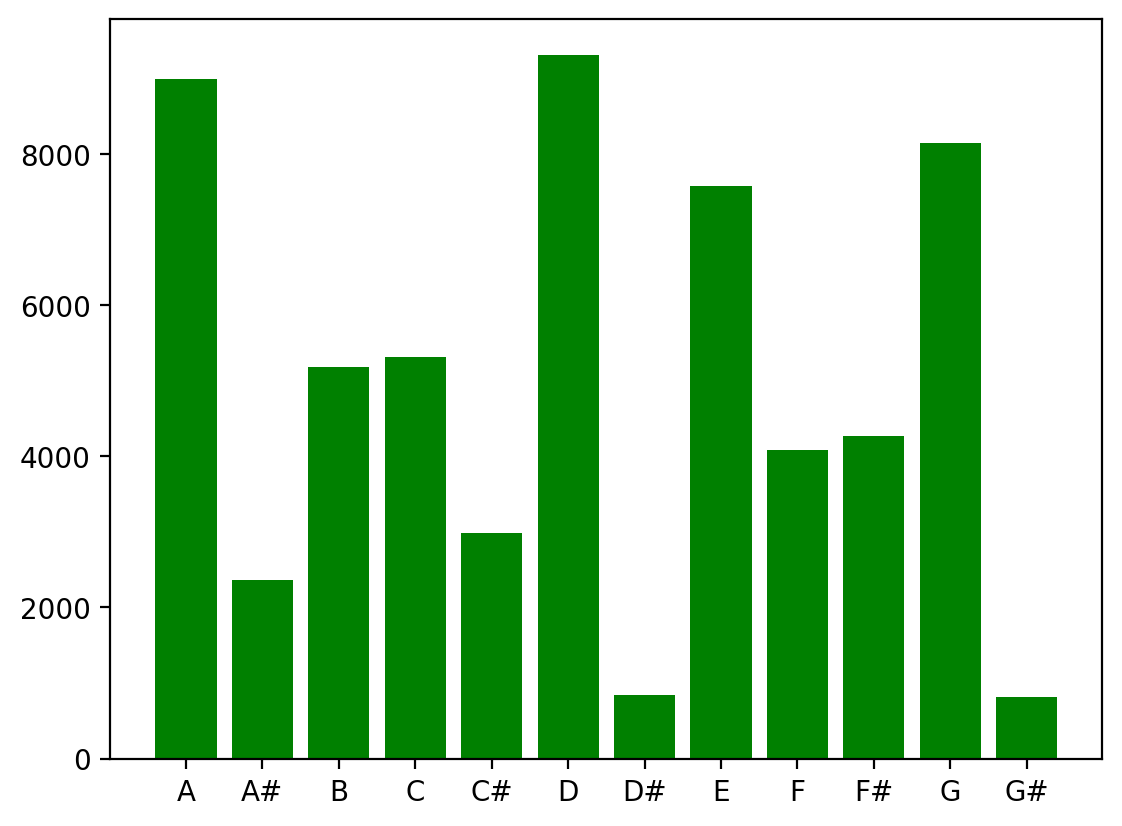

In [97]:
# Tonal character

all_beats = []
for score in slangpolska_scores:
    for note in slangpolska_scores[score].recurse().notesAndRests:
        try:
            tmp = ''
            pitch = note.name
            if pitch == 'C#' or pitch == 'D-':
                tmp = 'C#'
            if pitch == 'D#' or pitch == 'E-':
                tmp = 'D#'
            if pitch == 'F' or pitch == 'E#':
                tmp = "F"
            if pitch == 'G#' or pitch == 'A-':
                tmp = "G#"
            if pitch == 'A#' or pitch == 'B-':
                tmp = "A#"
            if pitch == 'B':
                tmp = "B"
            if tmp != '':
                all_beats.append(tmp)
            else:
                all_beats.append(note.name)
        except:
            pass
note_pitches = collections.Counter(all_beats).most_common(100)

dist_dict = {}
for pitch in note_pitches:
    if pitch[0] != 'rest':
        dist_dict[pitch[0]] = pitch[1]

myKeys = list(dist_dict.keys())
myKeys.sort()
dist_dict = {i: dist_dict[i] for i in myKeys}

# Quick look at onsets

#import matplotlib.pyplot as plt
plt.bar(list(dist_dict.keys()), dist_dict.values(), color='g')
plt.show()
#plt.plot(onset_distribution['atomic_moment'], onset_distribution['frequency'], color='red', marker='o')
#plt.title('Onset Distribution', fontsize=14)
#plt.xlabel('Measure (tick indicates first beat)', fontsize=14)
#plt.xticks([1, 4, 7, 10], ['1','2','3','4'])
#plt.ylabel('Frequency', fontsize=14)
#plt.grid(True)
#plt.show()

In [9]:
# Exploration stops here. 

Output notes for model development

In [4]:
# Output notes for ML generative model - abandoned, saving for future use if neeeded
score_name = []
measure_number = []
beat = []
duration = []
pitch = []
chord = []
event_type = []
for i,score in enumerate(slangpolska_scores):
    curr_score = slangpolska_scores[score]
    for event in curr_score.recurse().notesAndRests:
        score_name.append(score)
        measure_number.append(event.measureNumber)
        beat.append(event.beat)
        duration.append(event.duration.quarterLength)
        try:
            pitch.append(event.name)
        except:
            pitch.append(None)
        try:
            chord.append(event.pitchClasses)
        except:
            chord.append(None)
        event_type.append(str(type(event)))
print(score_name)
dnotes = pd.DataFrame(list(zip(score_name, measure_number, beat, duration, pitch, chord, event_type)),
               columns =['Score Name','Measure','Onset','Duration','Pitch','Chord','Event'])
dnotes.to_pickle("./dnotes.pkl")

['3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml', '3679c385a618c89f00d159f418022b39.xml',

# Generation

In [6]:
# Random generation - note to TAs: our random model generates one measure at a time, choosing randomly from the notes in the list called durations.
# Only notes that will not surpass the end of the third beat of the measure can be added at any given point

# Random
import random
def random_measure():
    durations = [3, 2, 1, 1/2, 1/4, 1/8]
    pitches = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    
    beat_limit = 3
    def select_notes(durations, pitches, beat_limit):
        # initialize the current sum and selected numbers list
        current_beat_sum = 0
        selected = []

        # randomly select durations until their sum equals beat_limit
        while current_beat_sum != beat_limit:
            # randomly select a duration from the durations array
            dur = random.choice(durations)
            if current_beat_sum + min(durations) > beat_limit:
                dur = beat_limit - current_beat_sum
            # if adding the selected duration would exceed the beats in measure, skip it
            elif current_beat_sum + dur > beat_limit:
                continue
            # add the selected duration to the current sum and then to selected list alongside a random pitch
            current_beat_sum += dur
            pit = random.choice(pitches)
            selected.append((dur, pit))
        return selected
    
    return select_notes(durations, pitches, beat_limit)

In [7]:
# Create sets of 8 random measures
# FOR TAs: here we saved random.pkl as random_final.pkl once to calculate distances. No longer _final so we don't overwrite. 
random_set_list_fmt = []
for run in range(500):
    new_rand_tmp = []
    for measure in range(8):
        new_rand_tmp.append(random_measure())
    #print(new_rand_tmp)
    random_set_list_fmt.append([event for measure in new_rand_tmp for event in measure])

# Music21 doesn't like being saved as pkl and reloaded. Save lists instead.
with open('lists_for_generation/randoms.pkl', 'wb') as f: # randoms_final SEE COMMENT ABOVE
    pickle.dump(random_set_list_fmt, f)

In [ ]:
# BIGRAMS
# MESSAGE TO TA: some of us have issues with this in VSCode. Others do not. If your IDE is giving you issues,
# you are advised to ctrl+f 'for run in range(25)' and change 25 to a lower number (this will produce a smaller amount 
# of generated rhythms before saving, allowing you to recover the file and proceed). Then proceed to 
# the next code block to pull in the generated file and, with the next few blocks, create the generated music21 score
# Try-except to catch error based on bigram that doesn't appear in corpus (explained further in paper). Basically, restarts
# the sequence if such a circumstance occurs.

from collections import Counter
from itertools import chain
import random

def get_note(_quarterLength, _beat, _pitch):
    return {
        "duration": _quarterLength,
        "beat": _beat,
        "pitch": _pitch
    }
def bigrams_start_notes():
    return bigrams_start_notes
    
def first_measure_note(): 
    return {
        "duration": "start_tag",
        "beat": -1,
        "pitch": "Z"
    }
    
def last_measure_note():
    return {
        "duration": "end_tag",
        "beat": -1,
        "pitch": "Z"
    }

def init_model():
    # bigrams for the durations and pitches
    durations = []
    # gather bigram statistics type:
    # iterate over all the corpus, measure by measure and fill the array of the notes
    bigrams_notes = [] # a list of lists of tuples [[("2", "b")], [("1", "a")]] -> return Counter(chain(*self.tupel_word_dict))
    bigrams_start_notes = []
    for piece in slangpolska_scores:
        sample_score = slangpolska_scores[piece]
        curr_measure = 0
        first_measure_note = {
            "duration": "start_tag",
            "beat": -1,
            "pitch": "Z"
        }
        last_measure_note = {
            "duration": "end_tag",
            "beat": -1,
            "pitch": "Z"
        }
        last_note = first_measure_note
        measure = []
        for i in sample_score.recurse().notes:
            if i.measureNumber != curr_measure:
                if last_note["duration"] != "start_tag":
                    bigrams_notes.append((last_note, last_measure_note))
                    last_note = first_measure_note
                    curr_measure = i.measureNumber
            # makes sure we are not in type Chord
            if hasattr(i, "name"):
                bigrams_notes.append((last_note, get_note(i.duration.quarterLength, i.beat ,i.pitch)))
                if curr_measure > 0:
                    if bigrams_notes[-1][0]["duration"] == "start_tag":
                        bigrams_start_notes.append((bigrams_notes[-2][0], bigrams_notes[-1][1])) # adding the last note in the last measure and the first measure in the new measure
            else:
                continue
            last_note = get_note(i.duration.quarterLength, i.beat, i.pitch)
            durations.append(last_note["duration"])
        bigrams_notes.append((last_note, last_measure_note))

    durations = list(set(durations))
    bigrams_durations = durations # kaede add
    print(bigrams_notes[:100])

    return bigrams_notes, bigrams_durations, bigrams_start_notes 

#bigrams_notes, bigrams_durations, bigrams_start_notes = init_model()

def generate_measures(bigrams_notes, bigrams_durations, bigrams_start_notes):
    # Generate a sequence within a squence of 8 measures, each measure created with a context of having a start and end note. Building the measure from start to end within this given random context
    measures = []

    #print(bigrams_start_notes[:10]) # kaede comment out
    #print(bigrams_notes[:10]) # kaede comment out
    # do the range till 6
    for i in range(8):
        measure = []
        total_duration = 0
        
        if measures:
            previous_measure_last_note = measures[-1][-1]
            # print("last measure: ", previous_measure_last_note) # kaede comment out
            bigrams_candidates_start_note = [bigram[1] for bigram in bigrams_start_notes if bigram[0] == previous_measure_last_note]
        # get all possible relevant candidates based on the last note plus that are in duration candidates
        else:
            bigrams_candidates_start_note = [bigram[1] for bigram in bigrams_notes if bigram[0] == first_measure_note()]
            # print(first_measure_note()) # kaede comment out
        # add first note
        first_note = random.choice(bigrams_candidates_start_note)
        measure.append(first_note)
        total_duration = first_note["duration"]
        
        # add last note if possible
        possible_durations = list(filter(lambda x: x <= 3 - total_duration, bigrams_durations)) # kaede add bigrams_ to durations
        bigrams_candidates_end_note = [bigram[0] for bigram in bigrams_notes if bigram[1] == last_measure_note() and bigram[0]["duration"] in possible_durations]
        # in case the first note is a full measure
        if (not bigrams_candidates_end_note):
            measure.append(last_measure_note())
            break
        last_note = random.choice(bigrams_candidates_end_note)
        measure.append(last_note)
        total_duration += last_note["duration"]

        while (total_duration < 3):
            previous_note = measure[-2] # last appended note
            duration_candidates = list(filter(lambda x: x <= 3 - total_duration, bigrams_durations)) # kaede add bigrams_ to durations
            if not duration_candidates: # in case the fraction messed up the summation
                break
            # get all possible relevant candidates based on the last note plus that are in duration candidates
            bigrams_candidates = [bigram[1] for bigram in bigrams_notes if bigram[0] == previous_note and bigram[1]["duration"] in duration_candidates]
            bigrams_candidates = bigrams_candidates + [bigram[0] for bigram in bigrams_notes if bigram[1] == last_note and bigram[0]["duration"] == 3 - total_duration] # get all gap fillers
            # random weighted pick
            next_note = random.choice(bigrams_candidates)
            total_duration += next_note["duration"]
            measure.insert(len(measure) - 1, next_note) # inserts it on the position before the last one
        measures.append(measure)

    # for m in measures: # kaede comment out
    #    print(m)
    
    return measures

import calendar
import time
import random
current_GMT = time.gmtime()

def attempt_25_bigrams(l):
    bigrams_notes, bigrams_durations, bigrams_start_notes = init_model()
    bigram_set = []
    for run in range(25): # THIS IS THE NUMBER YOU CHANGE IF YOUR IDE IS GIVING YOU TROUBLE
        print(run)
        bigram_tmp = generate_measures(bigrams_notes, bigrams_durations, bigrams_start_notes)
        bigram_set.append(bigram_tmp)
    bigram_set_list_fmt = []
    for i, generated_score in enumerate(bigram_set):
        tmp = []
        for j, measure in enumerate(generated_score):
            for k, event in enumerate(measure):
                tmp.append((bigram_set[i][j][k]['duration'], bigram_set[i][j][k]['pitch'].name))
        bigram_set_list_fmt.append(tmp)

    # Music21 doesn't like being saved as pkl and reloaded. Save lists instead.
    time_stamp = calendar.timegm(current_GMT)
    with open('bigrams_' + str(time_stamp) + '_' + str(l) + '.pkl', 'wb') as f:
        pickle.dump(bigram_set_list_fmt, f)

i = 0
while i < 20:
    try:
        attempt_25_bigrams(i)
        i += 1
    except:
        pass

In [52]:
# FOR TAs: here we saved bigrams.pkl as bigrams_final.pkl once to calculate distances. No longer _final so we don't overwrite. 
# TAS: also change your directory to where you saved bigrams_*_*.pkl in the previous block
import pickle
import glob, os
os.chdir("C:/Users/HP/DH401-A1-RHYTHMGEN/DH401-A1-RHYTHMGEN/")
files = []
for file in glob.glob("bigrams_*_*.pkl"):
    files.append(file)
samples = []
for filename in files:
    with open(filename, 'rb') as f:
        x = pickle.load(f)
        samples.append(x)
bigram_set_list_fmt_tmp = [lst for list in samples for lst in list]
bigram_set_list_fmt_tmp = bigram_set_list_fmt_tmp[0:500]
bigram_set_list_fmt = []
for score in bigram_set_list_fmt_tmp:
    score_list = []
    for event in score:
        tmp = -2
        if event[1] == 'C':
            tmp = 0
        if event[1] == 'C#' or event[1] == 'D-':
            tmp = 1
        if event[1] == 'D':
            tmp = 2
        if event[1] == 'D#' or event[1] == 'E-':
            tmp = 3
        if event[1] == 'E':
            tmp = 4
        if event[1] == 'F' or event[1] == 'E#':
            tmp = 5
        if event[1] == 'F#':
            tmp = 6
        if event[1] == 'G':
            tmp = 7
        if event[1] == 'G#' or event[1] == 'A-':
            tmp = 8
        if event[1] == 'A':
            tmp = 9
        if event[1] == 'A#' or event[1] == 'B-':
            tmp = 10
        if event[1] == 'B':
            tmp = 11
        if tmp == -2:
            print(event[1])
        score_list.append((event[0],tmp))
    bigram_set_list_fmt.append(score_list)

print(len(bigram_set_list_fmt))

with open('lists_for_generation/bigrams.pkl', 'wb') as f: #bigrams_final.pkl SEE COMMENT ABOVE
    pickle.dump(bigram_set_list_fmt, f)


500


Create music21 scores from lists in block below. See helpers.py for conversion function (adapted from tutorial files)

In [35]:
# This block creates music21 scores out of the bigram-generated lists and randomly generated lists

with open('lists_for_generation/randoms_final.pkl', 'rb') as f:
    random_set_list_fmt = pickle.load(f)

generated_from_random = []
for i,generated_score in enumerate(random_set_list_fmt):
    score = score_from_sequence(random_set_list_fmt[i], time_sig='3/4')
    #score.show()
    generated_from_random.append(score)

with open('lists_for_generation/bigrams_final.pkl', 'rb') as f:
    bigram_set_list_fmt = pickle.load(f)

generated_from_bigrams = []
for i,generated_score in enumerate(bigram_set_list_fmt):
    score = score_from_sequence(bigram_set_list_fmt[i], time_sig='3/4')
    #score.show()
    generated_from_bigrams.append(score)

print("# of random scores:")
print(len(generated_from_random))
print("# of bigram scores:")
print(len(generated_from_bigrams))

# of random scores:
500
# of bigram scores:
500


In [55]:
# Generated scores to xml -> be sure to push these to github when done 
for i, score in enumerate(generated_from_bigrams):
    tmp_xml = stream.Score(generated_from_bigrams[i])
    tmp_xml.write("xml", 'bigrams_final/bigrams_' + str(i) + '.xml')
for i, score in enumerate(generated_from_random):
    tmp_xml = stream.Score(generated_from_random[i])
    tmp_xml.write("xml", 'random_final/random_' + str(i) + '.xml')

# Compare Corpuses (Rhythm)

In [16]:
# Pull in slangpolska (helpful to have command down here during testing)
xml_file_location = 'C:/Users/HP/anaconda3/envs/digital_musicology/xml/'
slangpolska_scores = import_slangpolskas(xml_file_location, keepScoresWithChords=False)

  1%|          | 6/600 [00:00<00:10, 59.11it/s]

excluding 1b651a94a8f8680da3cef1e60705194d.xml. Only 4 measures.
excluding 32a7f688d6c7ffc643473e7067ab5945.xml. Only 1 measures.
excluding 60ae81952628613e03d563b0dae8bbc2.xml. Only 2 measures.
excluding 6a7d307d1f0712090e4043a6b4637efa.xml. Only 3 measures.
excluding 8c6965e3c831e8cb769e578423c12d1e.xml. Only 4 measures.
excluding a0e1af6a94ac4663c193e7d6d9818189.xml. Only 3 measures.
excluding Brännvinspolonäs_efter_Rondahl_i_C_f67b5f.xml. A chord was found in the first 8 measures.
excluding En_sup_till__polska_efter_Jan_Erik_Hammarberg_9d21b6.xml. A chord was found in the first 8 measures.


  3%|▎         | 18/600 [00:00<00:13, 41.79it/s]

excluding Flickornas_Michaelidans_0ae676.xml. A chord was found in the first 8 measures.


  6%|▌         | 33/600 [00:00<00:14, 38.97it/s]

excluding Ninas_slängpolska_20240b.xml. 2 meter(s), first is 3/4
excluding Näckapolska_efter_Anders_Bredal_c55b3d.xml. A chord was found in the first 8 measures.


  8%|▊         | 45/600 [00:01<00:14, 37.95it/s]

excluding Pollonesse_183216_28c0df.xml. A chord was found in the first 8 measures.


 10%|▉         | 58/600 [00:01<00:14, 36.76it/s]

excluding Pollonesse_183227_7f7f8e.xml. A chord was found in the first 8 measures.
excluding Pollonesse_183231_54a1b9.xml. A chord was found in the first 8 measures.


 13%|█▎        | 77/600 [00:01<00:12, 41.19it/s]

excluding Pollonesse_183256_adcf61.xml. A chord was found in the first 8 measures.
excluding Pollonesse_ur_Andreas_Dahlgrens_notbok_no_55_7586c6.xml. A chord was found in the first 8 measures.


 14%|█▍        | 87/600 [00:02<00:13, 38.47it/s]

excluding Pollonesse_ur_Andreas_Dahlgrens_notbok_no_84_f2a90d.xml. A chord was found in the first 8 measures.
excluding Pollonesse_ur_Andreas_Dahlgrens_notbok_nr_15_b3ef5f.xml. A chord was found in the first 8 measures.


 16%|█▌        | 95/600 [00:02<00:18, 27.97it/s]

excluding Pollonesse_ur_Andreas_Dahlgrens_notbok_nr_45_8e189b.xml. A chord was found in the first 8 measures.
excluding Pollonesse_ur_Elias_Annells_notbok_721f04.xml. A chord was found in the first 8 measures.


 18%|█▊        | 106/600 [00:02<00:13, 37.15it/s]

excluding Polonesse_in_A_Dur_No_5_63fd7d.xml. A chord was found in the first 8 measures.
excluding Polonesse_in_A_Moll_no_4_ur_Anders_Larssons_notbok_900ea5.xml. A chord was found in the first 8 measures.
excluding Polonesse_in_G_Dur_no_10_ur_Anders_Larssons_notbok_242fbc.xml. A chord was found in the first 8 measures.


 21%|██        | 125/600 [00:03<00:09, 49.18it/s]

excluding Polonesse_in_G_Dur_no_17_ur_Anders_Larssons_notbok_13aa5c.xml. A chord was found in the first 8 measures.
excluding Polonesse_in_G_Dur_no_19_ur_Anders_Larssons_notbok_b9f251.xml. A chord was found in the first 8 measures.


 24%|██▍       | 145/600 [00:03<00:08, 55.58it/s]

excluding Poloness_ur_Andreas_Hööks_notbok_cae293.xml. 4 meter(s), first is 2/2
excluding Polonisse_258390.xml. A chord was found in the first 8 measures.
excluding Polonoise_92b598.xml. 2 meter(s), first is 3/4
excluding Polonoise_No_30_ur_Stakels_notsamling_90c44f.xml. Only 6 measures.


 27%|██▋       | 163/600 [00:03<00:08, 51.15it/s]

excluding Polonäs_3a2fff.xml. A chord was found in the first 8 measures.


 28%|██▊       | 170/600 [00:03<00:07, 53.80it/s]

excluding Polonäs_a39d56.xml. A chord was found in the first 8 measures.
excluding Polonäs_a7d328.xml. A chord was found in the first 8 measures.


 32%|███▏      | 193/600 [00:06<00:24, 16.41it/s]

excluding Polonäs_de6b05.xml. A chord was found in the first 8 measures.


 34%|███▍      | 205/600 [00:07<00:15, 25.75it/s]

excluding Polonäs_efter_Andreas_Grevelius_nr_76_37a872.xml. A chord was found in the first 8 measures.
excluding Polonäs_efter_Gustaf_Weslien_2981d4.xml. Only 6 measures.


 40%|███▉      | 239/600 [00:07<00:08, 44.98it/s]

excluding Polonäs_efter_Rondahl_i_D__Bröllopspolska_63bc14.xml. A chord was found in the first 8 measures.


 43%|████▎     | 257/600 [00:08<00:09, 37.55it/s]

excluding Polonäs_fd6cd9.xml. A chord was found in the first 8 measures.


 47%|████▋     | 281/600 [00:08<00:06, 46.05it/s]

excluding Polonäs_i_Dm_6584f0.xml. A chord was found in the first 8 measures.
excluding Polonäs_i_Dm_efter_Daniel_Danielsson_ac3754.xml. 2 meter(s), first is 3/4
excluding Polonäs_i_Dm_efter_Jean_E_Blomgren_615fdd.xml. A chord was found in the first 8 measures.


 49%|████▊     | 292/600 [00:08<00:06, 44.88it/s]

excluding Polonäs_i_Dm_efter_Nils_Larsson_1cc00b.xml. A chord was found in the first 8 measures.


 51%|█████     | 307/600 [00:09<00:06, 42.39it/s]

excluding Polonäs_i_Gm_efter_Baumgarten_414887.xml. A chord was found in the first 8 measures.


 53%|█████▎    | 317/600 [00:09<00:06, 41.48it/s]

excluding Polonäs_sexdregasamlingen_del_3_nr_1_d8c3dc.xml. 2 meter(s), first is 3/4
excluding Polonäs_ur_Alfred_Anderssons_notbok_453338.xml. A chord was found in the first 8 measures.
excluding Polonäs_ur_Andreas_Dahlgrens_notbok_nr_1_b129a2.xml. A chord was found in the first 8 measures.


 59%|█████▉    | 353/600 [00:10<00:05, 43.64it/s]

excluding Polska_af_Hagbyen_af_Etelhem_socken_å_Gotland_50736e.xml. A chord was found in the first 8 measures.
excluding Polska_d10d31.xml. A chord was found in the first 8 measures.
excluding Polska_efter_Anders_Gustaf_Andersson_229504.xml. A chord was found in the first 8 measures.
excluding Polska_efter_Anders_Gustaf_Andersson_e1e8d7.xml. A chord was found in the first 8 measures.


 60%|██████    | 363/600 [00:10<00:05, 41.21it/s]

excluding Polska_efter_Bengt_Håkansson_b405db.xml. A chord was found in the first 8 measures.
excluding Polska_efter_ByssKalle_nr_32_5e25b2.xml. A chord was found in the first 8 measures.
excluding Polska_efter_Ida_i_Rye_4b4d84.xml. A chord was found in the first 8 measures.


 64%|██████▍   | 383/600 [00:11<00:05, 40.29it/s]

excluding Polska_efter_Wesslén_8cb9d2.xml. A chord was found in the first 8 measures.
excluding Polska_efter_Wesslén_bec4ac.xml. 2 meter(s), first is 3/4
excluding Polska_efter_Wesslén_ce0449.xml. 2 meter(s), first is 3/4
excluding Polska_efter_Wesslén_fc5278.xml. 2 meter(s), first is 3/4


 66%|██████▋   | 399/600 [00:11<00:04, 46.66it/s]

excluding Polska_från_Västergötland_4b64d8.xml. 3 meter(s), first is 3/4
excluding Polska_i_G_dur_efter_Alfred_Pettersson_Svl_292_626b41.xml. A chord was found in the first 8 measures.


 67%|██████▋   | 404/600 [00:11<00:04, 42.79it/s]

excluding Polska_ur_kantor_P_A_Isséns_samling_f1d0d4.xml. A chord was found in the first 8 measures.
excluding Polska__0e3f18.xml. A chord was found in the first 8 measures.


 69%|██████▉   | 414/600 [00:11<00:04, 41.05it/s]

excluding Slängpolska_efter_AG_Andersson_24d50d.xml. A chord was found in the first 8 measures.
excluding Slängpolska_efter_Appelkvist_3f94c8.xml. A chord was found in the first 8 measures.
excluding Slängpolska_fr_Slimminge_60b292.xml. A chord was found in the first 8 measures.
excluding Slängpolska_från_Torna_Hällestad_d2f7e4.xml. A chord was found in the first 8 measures.
excluding Sydjämtsk_slängpolska_efter_JohnErik_Mattsson_2a0874.xml. 2 meter(s), first is 3/4


 72%|███████▏  | 430/600 [00:12<00:04, 41.32it/s]

excluding _Ack_om_den_lilla_vännen_komme_slängpolska_e45976.xml. A chord was found in the first 8 measures.
excluding _Forstälds_Polska_26c4d6.xml. A chord was found in the first 8 measures.


 76%|███████▌  | 457/600 [00:12<00:02, 48.08it/s]

excluding _Polonesse_in_G_Dur_no_12_ur_Anders_Larssons_notbok_e3c5b0.xml. A chord was found in the first 8 measures.


 78%|███████▊  | 467/600 [00:13<00:02, 47.10it/s]

excluding _Polonäs_sexdregasamlingen_del_1_nr_124_aa665f.xml. A chord was found in the first 8 measures.
excluding _Polonäs_sexdregasamlingen_del_1_nr_145_84412a.xml. A chord was found in the first 8 measures.
excluding _Polonäs_sexdregasamlingen_del_1_nr_16_f74392.xml. A chord was found in the first 8 measures.
excluding _Polonäs_sexdregasamlingen_del_1_nr_36_dfc2c9.xml. 2 meter(s), first is 3/4


 80%|███████▉  | 478/600 [00:13<00:02, 49.41it/s]

excluding _Polonäs_sexdregasamlingen_del_1_nr_36_ed2b21.xml. 2 meter(s), first is 3/4


 82%|████████▏ | 490/600 [00:13<00:02, 52.81it/s]

excluding _Polonäs_sexdregasamlingen_del_2_nr_1_69278c.xml. A chord was found in the first 8 measures.


 87%|████████▋ | 524/600 [00:17<00:03, 21.58it/s]

excluding _Polonäs_sexdregasamlingen_del_3_nr_5__a87d42.xml. A chord was found in the first 8 measures.
excluding _Polonäs_ur_Andreas_Dahlgrens_notbok_nr_3_ec2fcd.xml. A chord was found in the first 8 measures.


 91%|█████████ | 544/600 [00:17<00:01, 35.15it/s]

excluding _Polonäs_ur_Andreas_Dahlgrens_notbok_nr_8_564b4f.xml. A chord was found in the first 8 measures.
excluding _Polska_efter_August_Nyholm_Delsbo_48daf3.xml. A chord was found in the first 8 measures.
excluding _Polska_efter_ByssKalle_nr_22_299bd4.xml. A chord was found in the first 8 measures.


 94%|█████████▍| 564/600 [00:18<00:00, 36.10it/s]

excluding _Polska_efter_ByssKalle_nr_6_e7faa3.xml. A chord was found in the first 8 measures.
excluding _Polska_efter_Futteri_Petter_f19eaf.xml. A chord was found in the first 8 measures.
excluding _Polska_efter_Gustav_Strutz_21bb05.xml. 5 meter(s), first is 3/4
excluding _Polska_efter_Gustav_Strutz_5b7324.xml. 5 meter(s), first is 3/4


 96%|█████████▌| 576/600 [00:18<00:00, 40.86it/s]

excluding _Polska_efter_Petter_Dufva_820a4f.xml. A chord was found in the first 8 measures.


 99%|█████████▉| 593/600 [00:18<00:00, 46.74it/s]

excluding _Polska_Kringellåt_efter_Snickar_Erik_13e2a2.xml. A chord was found in the first 8 measures.
excluding _Polska_Kringellåt_efter_Snickar_Erik_7554db.xml. A chord was found in the first 8 measures.
excluding _Polska_Kringellåt_efter_Snickar_Erik_985b63.xml. 3 meter(s), first is 4/4


100%|██████████| 600/600 [00:18<00:00, 31.63it/s]

Imported 512 scores into corpus. Excluded 87 due to inconsistent meter, polyphonic setup, less than 8 measures, or chord presence in the first 8 measures.


In [17]:
# This should be reinitialized if you want to run the rhythm distance fresh
full_chronotonic_sequence_holder = {}

In [18]:
# Chronotonic comparisons - see helpers.py for underlying functions
# As of 20230410, this block calculates the geographic distance between the first 8 bars
# of chronotonic rhythm sequences between each score in set a and each score in set b (sets a and b can be the same).
#
# Note compare() is the same distance function used for pitch; arguments specify rhythm in this case
# full_chronotonic_sequence_holder SHOULD BE REINITIALIZED IF ANYTHING ABOUT THE DISTANCE CALCULATION CHANGES

# Combinations:
# orig-orig
# orig-rand
# orig-bigr
# bigr-bigr
# bigr-rand
# rand-rand
print('Calculating orig-orig. Rhythm distance task 1/6')
full_chronotonic_sequence_holder = compare(slangpolska_scores, slangpolska_scores, 'orig', 'orig', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating orig-rand. Rhythm distance task 2/6')
full_chronotonic_sequence_holder = compare(slangpolska_scores, generated_from_random, 'orig', 'rand', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating orig-bigr. Rhythm distance task 3/6')
full_chronotonic_sequence_holder = compare(slangpolska_scores, generated_from_bigrams, 'orig', 'bigr', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating bigr-bigr. Rhythm distance task 4/6')
full_chronotonic_sequence_holder = compare(generated_from_bigrams, generated_from_bigrams, 'bigr', 'bigr', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating bigr-rand. Rhythm distance task 5/6')
full_chronotonic_sequence_holder = compare(generated_from_bigrams, generated_from_random, 'bigr', 'rand', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating rand-rand. Rhythm distance task 6/6')
full_chronotonic_sequence_holder = compare(generated_from_random, generated_from_random, 'rand', 'rand', 'rhythm', full_chronotonic_sequence_holder)

    

Calculating orig-orig. Rhythm distance task 1/6


100%|██████████| 512/512 [15:30<00:00,  1.82s/it]


Calculating orig-rand. Rhythm distance task 2/6


100%|██████████| 512/512 [25:41<00:00,  3.01s/it]


Calculating orig-bigr. Rhythm distance task 3/6


100%|██████████| 512/512 [27:36<00:00,  3.24s/it]


Calculating bigr-bigr. Rhythm distance task 4/6


100%|██████████| 500/500 [11:13<00:00,  1.35s/it]


Calculating bigr-rand. Rhythm distance task 5/6


100%|██████████| 500/500 [21:03<00:00,  2.53s/it]


Calculating rand-rand. Rhythm distance task 6/6


100%|██████████| 500/500 [10:58<00:00,  1.32s/it]


# Compare Corpuses (Pitch Sequence)

In [4]:
# First, create distribution of Levenshtein distance operations in orig-orig 
# to re-weight insertions, deletions, and substitutions for ultimate pitch distance calculations
# adapted from https://pypi.org/project/python-Levenshtein/
import Levenshtein
import tqdm
from collections import Counter

# function to find edit operations involved in shortest edit distance between two strings
def editops_as_ascii(str1, str2):
    editops_indices = Levenshtein.editops(str1, str2)
    insertions = []
    deletions = []
    substitutions = []
    for operation in editops_indices:
        if operation[0] == 'insert':
            insertions.append((operation[0], str2[operation[2]]))
        if operation[0] == 'delete':
            deletions.append((operation[0], str1[operation[1]]))
        if operation[0] == 'replace':
            substitutions.append((operation[0], str1[operation[1]], str2[operation[2]]))
    return insertions, deletions, substitutions

# create distribution of all edit operations for all orig-orig pitch sequences
insertions_nonflat = []
deletions_nonflat = []
substitutions_nonflat = []
for score_i in tqdm.tqdm(slangpolska_scores.keys()):
    for score_j in list(slangpolska_scores):
        insertions, deletions, substitutions = editops_as_ascii(pitch_sequence(slangpolska_scores[score_i]), pitch_sequence(slangpolska_scores[score_j]))
        insertions_nonflat.append(insertions)
        deletions_nonflat.append(deletions)
        substitutions_nonflat.append(substitutions)
insertions_tot = [op for oplist in insertions_nonflat for op in oplist]
deletions_tot = [op for oplist in deletions_nonflat for op in oplist]
substitutions_tot = [op for oplist in substitutions_nonflat for op in oplist]

all_operations_tot = insertions_tot + deletions_tot + substitutions_tot
d = Counter(all_operations_tot)
distribution = [(i, d[i] / len(all_operations_tot)) for i in d]

100%|██████████| 512/512 [09:23<00:00,  1.10s/it]


In [6]:
# Ensure symmetric operations are equal cost
pitches = ["A","B","C","D","E","F","G","a","b","c","d","e","f","g"]
distribution_reweighted = []
for pitch_i in pitches:
    for pitch_j in pitches:
        if pitch_i != pitch_j:
            replace_symm_i_j = -1
            replace_i_j_tmp = -1
            replace_j_i_tmp = -1
            found = 0
            for operation in distribution:
                if operation[0][0] == 'replace' and operation[0][1] == pitch_i and operation[0][2] == pitch_j:
                    replace_i_j_tmp = operation[1]
                if operation[0][0] == 'replace' and operation[0][1] == pitch_j and operation[0][2] == pitch_i:
                    replace_i_j_tmp = operation[1]
                if replace_i_j_tmp != -1 and replace_j_i_tmp != -1:
                    replace_symm_i_j = (replace_i_j_tmp + replace_j_i_tmp) / 2
                    found = 1
                if found == 1:
                    break
            if replace_symm_i_j == -1 and replace_i_j_tmp != -1:
                replace_symm_i_j = replace_i_j_tmp
            if replace_symm_i_j == -1 and replace_j_i_tmp != -1:
                replace_symm_i_j = replace_j_i_tmp
            distribution_reweighted.append((('replace', pitch_i, pitch_j), replace_symm_i_j))
            distribution_reweighted.append((('replace', pitch_j, pitch_i), replace_symm_i_j))
    insdel_symm_i = -1
    insert_i_tmp = -1
    delete_i_tmp = -1
    found = 0
    for operation in distribution:
        if operation[0][0] == 'insert' and operation[0][1] == pitch_i:
            insert_i_tmp = operation[1]
        if operation[0][0] == 'delete' and operation[0][1] == pitch_i:
            delete_i_tmp = operation[1]
        if insert_i_tmp != -1 and delete_i_tmp != -1:
            insdel_symm_i = (insert_i_tmp + delete_i_tmp) / 2
            found = 1
        if found == 1:
            break
    if insdel_symm_i == -1 and insert_i_tmp != -1:
        insdel_symm_i = insert_i_tmp
    if insdel_symm_i == -1 and delete_i_tmp != -1:
        insdel_symm_i = delete_i_tmp
    distribution_reweighted.append((('insert', pitch_i), insdel_symm_i))
    distribution_reweighted.append((('delete', pitch_i), insdel_symm_i))

global_min = 1
distribution_reweighted_final = []
for operation in distribution:
    if operation[1] < global_min:
        global_min = operation[1]
for operation in distribution_reweighted:
    if operation[1] == -1:
        distribution_reweighted_final.append((operation[0],global_min))
    else:
        distribution_reweighted_final.append(operation)
        
#print(len(distribution))
print(len(distribution_reweighted_final))

392


In [7]:
# Set up new Levenshtein costs based on distribution of operations from orig-orig

# New costs will range from 1 to a nearby real number greated than 1. The most frequent operation will be cost 1, and the least common will be 
# maximum cost. Let s[i] = event i's share in all edit distance events. Then c[i], the cost of the edit distance event i, equals 
# ((ln(s[i]) / max(ln(s[j]))), where j can be any possible event in orig-orig events.
# As of 04102023 the range is 1 to about 2.44.

import copy
costs = copy.deepcopy(distribution_reweighted_final)
running_max = -1000
for i in range(len(costs)):
    tmp = np.log(costs[i][1])
    costs[i] = (costs[i][0], tmp)
    if tmp > running_max:
        running_max = tmp
running_max_converted = -1
for i in range(len(costs)):
    costs[i] = (costs[i][0], (costs[i][1] / running_max))
    if costs[i][1] > running_max_converted:
        running_max_converted = costs[i][1]
print('Costs range between 1 and ' + str(running_max_converted))

insert_costs = np.zeros(128)
delete_costs = np.zeros(128)
substitute_costs = np.zeros([128,128])
for cost in costs:
    if cost[0][0] == 'insert':
        insert_costs[ord(cost[0][1])] = cost[1]
    if cost[0][0] == 'delete':
        delete_costs[ord(cost[0][1])] = cost[1]
    if cost[0][0] == 'replace':
        substitute_costs[ord(cost[0][1]), ord(cost[0][2])] = cost[1]

with open('levenshtein_costs/insert_costs.pkl', 'wb') as f:
    pickle.dump(insert_costs, f)
with open('levenshtein_costs/delete_costs.pkl', 'wb') as f:
    pickle.dump(delete_costs, f)
with open('levenshtein_costs/substitute_costs.pkl', 'wb') as f:
    pickle.dump(substitute_costs, f)


Costs range between 1 and 2.419911633756955


In [10]:
# Uncomment block to ensure pitch distance is symmetric even with reweighted costs

#with open('levenshtein_costs/insert_costs.pkl', 'rb') as f:
#    insert_costs = pickle.load(f)
#with open('levenshtein_costs/delete_costs.pkl', 'rb') as f:
#    delete_costs = pickle.load(f)
#with open('levenshtein_costs/substitute_costs.pkl', 'rb') as f:
#    substitute_costs = pickle.load(f)

#for score_i in tqdm.tqdm(slangpolska_scores.keys()):
#    for score_j in list(slangpolska_scores):
#        str1 = pitch_sequence(slangpolska_scores[score_i])
#        str2 = pitch_sequence(slangpolska_scores[score_j])
#        assert levenshtein(str1, len(str1), str2, len(str2), insert_costs, delete_costs, substitute_costs)  == levenshtein(str2, len(str2), str1, len(str1), insert_costs, delete_costs, substitute_costs)
#        #assert Levenshtein.distance(str1, str2) == Levenshtein.distance(str2, str1)
        

In [23]:
# Pitch-only edit distance comparisons, edit costs inversely weighted by orig-orig frequency - see helpers.py for underlying functions

# Combinations:
# orig-orig
# orig-rand
# orig-bigr
# bigr-bigr
# bigr-rand
# rand-rand
print('Calculating orig-orig. Pitch distance task 1/6')
compare(slangpolska_scores, slangpolska_scores, 'orig', 'orig', 'pitch')
print('Calculating orig-rand. Pitch distance task 2/6')
compare(slangpolska_scores, generated_from_random, 'orig', 'rand', 'pitch')
print('Calculating orig-bigr. Pitch distance task 3/6')
compare(slangpolska_scores, generated_from_bigrams, 'orig', 'bigr', 'pitch')
print('Calculating bigr-bigr. Pitch distance task 4/6')
compare(generated_from_bigrams, generated_from_bigrams, 'bigr', 'bigr', 'pitch')
print('Calculating bigr-rand. Pitch distance task 5/6')
compare(generated_from_bigrams, generated_from_random, 'bigr', 'rand', 'pitch')
print('Calculating rand-rand. Pitch distance task 6/6')
compare(generated_from_random, generated_from_random, 'rand', 'rand', 'pitch')

Calculating orig-orig. Pitch distance task 1/6


100%|██████████| 512/512 [18:50<00:00,  2.21s/it]


Calculating orig-rand. Pitch distance task 2/6


100%|██████████| 512/512 [25:59<00:00,  3.05s/it]


Calculating orig-bigr. Pitch distance task 3/6


100%|██████████| 512/512 [31:59<00:00,  3.75s/it]


Calculating bigr-bigr. Pitch distance task 4/6


100%|██████████| 500/500 [14:36<00:00,  1.75s/it]


Calculating bigr-rand. Pitch distance task 5/6


100%|██████████| 500/500 [23:40<00:00,  2.84s/it]


Calculating rand-rand. Pitch distance task 6/6


100%|██████████| 500/500 [08:59<00:00,  1.08s/it]


# Normalize and Combine Distance Functions into one metric

In [68]:
from mergedeep import merge

# Rhythm Distances
with open('all_distances/orig_to_orig_rhythm_distances.pkl', 'rb') as f:
    orig_to_orig_rhythm_distances = pickle.load(f)
with open('all_distances/orig_to_rand_rhythm_distances.pkl', 'rb') as f:
    orig_to_rand_rhythm_distances = pickle.load(f)
with open('all_distances/orig_to_bigr_rhythm_distances.pkl', 'rb') as f:
    orig_to_bigr_rhythm_distances = pickle.load(f)
with open('all_distances/bigr_to_bigr_rhythm_distances.pkl', 'rb') as f:
    bigr_to_bigr_rhythm_distances = pickle.load(f)
with open('all_distances/bigr_to_rand_rhythm_distances.pkl', 'rb') as f:
    bigr_to_rand_rhythm_distances = pickle.load(f)
with open('all_distances/rand_to_rand_rhythm_distances.pkl', 'rb') as f:
    rand_to_rand_rhythm_distances = pickle.load(f)

rhythm_distances = merge(orig_to_orig_rhythm_distances,orig_to_rand_rhythm_distances,orig_to_bigr_rhythm_distances,bigr_to_bigr_rhythm_distances,bigr_to_rand_rhythm_distances,rand_to_rand_rhythm_distances)

# Pitch Distances
with open('all_distances/orig_to_orig_pitch_distances.pkl', 'rb') as f:
    orig_to_orig_pitch_distances = pickle.load(f)
with open('all_distances/orig_to_rand_pitch_distances.pkl', 'rb') as f:
    orig_to_rand_pitch_distances = pickle.load(f)
with open('all_distances/orig_to_bigr_pitch_distances.pkl', 'rb') as f:
    orig_to_bigr_pitch_distances = pickle.load(f)
with open('all_distances/bigr_to_bigr_pitch_distances.pkl', 'rb') as f:
    bigr_to_bigr_pitch_distances = pickle.load(f)
with open('all_distances/bigr_to_rand_pitch_distances.pkl', 'rb') as f:
    bigr_to_rand_pitch_distances = pickle.load(f)
with open('all_distances/rand_to_rand_pitch_distances.pkl', 'rb') as f:
    rand_to_rand_pitch_distances = pickle.load(f)

pitch_distances = merge(orig_to_orig_pitch_distances,orig_to_rand_pitch_distances,orig_to_bigr_pitch_distances,bigr_to_bigr_pitch_distances,bigr_to_rand_pitch_distances,rand_to_rand_pitch_distances)

# Normalize Distances (rhythm and pitch normalized separately)
def normalize_nested_dict(dict):
    running_max = -1
    running_min = 1000
    for key_i in dict.keys():
        for key_j in dict[key_i].keys():
            if dict[key_i][key_j] > running_max:
                running_max = dict[key_i][key_j]
            if dict[key_i][key_j] < running_min:
                running_min = dict[key_i][key_j]
    for key_i in dict.keys():
        for key_j in dict[key_i].keys():
            dict[key_i][key_j] = (dict[key_i][key_j] - running_min) / (running_max - running_min)
    return dict

normalized_rhythm_distances = normalize_nested_dict(rhythm_distances)
normalized_pitch_distances = normalize_nested_dict(pitch_distances)

# Create aggregate distance dictionary of tuples; each value equals (normalized rhythm distance, normalized pitch distance)
## There should be no missing values; coding in this scenario due to incomplete distances while testing
all_distance_pairs_normalized = {}
for i in normalized_rhythm_distances.keys():
    all_distance_pairs_normalized[i] = {}
    for j in normalized_rhythm_distances[i].keys():
        tmp_rhythm = normalized_rhythm_distances[i][j]
        if normalized_pitch_distances.get(i,{}).get(j) is not None:
            tmp_pitch = normalized_pitch_distances[i][j]
        elif normalized_pitch_distances.get(j,{}).get(i) is not None:
            tmp_pitch = normalized_pitch_distances[j][i]
        else:
            tmp_pitch = -1
        all_distance_pairs_normalized[i][j] = (tmp_rhythm, tmp_pitch)

## This should not have any effect. Include during testing due to differences in 
## testing-phase rhythm and pitch comparison sets
#for k in normalized_pitch_distances.keys():
#    if all_distance_pairs_normalized.get(k) is None:
#        all_distance_pairs_normalized[k] = {}
#    for l in normalized_pitch_distances[k].keys():
#        tmp_pitch = normalized_pitch_distances[k][l]
#        if normalized_rhythm_distances.get(k,{}).get(l) is not None:
#            tmp_rhythm = normalized_rhythm_distances[k][l]
#        elif normalized_rhythm_distances.get(l,{}).get(k) is not None:
#            tmp_rhythm = normalized_rhythm_distances[l][k]
#        else:
#            tmp_rhythm = -1
#        all_distance_pairs_normalized[k][l] = (tmp_rhythm, tmp_pitch)



In [69]:
# Pull down minimum rhythm and pitch distances by score-category
# Use E(min(d(a,b))) framework discussed in tutorial.
# Exclude self-self score distance (0) in calculations

# Question - do we combine rhythm and pitch distances before or after E(min(d(a,b))) ?
# Keeping separate during development phase

def minimum_seeker(nested_distances_dict, set1, set2, curr_i, curr_j, comparison_type, curr_min):

    if comparison_type == "rhythm":
        element_to_take = 0
    elif comparison_type == "pitch":
        element_to_take = 1

    if set1 == "orig":
        set1 = '.xml'
    if set2 == "orig":
        set2 = '.xml'
    if set1 == "bigr":
        set1 = "bigr_"
    if set2 == "bigr":
        set2 = "bigr_"
    if set1 == "rand":
        set1 = "rand_"
    if set2 == "rand":
        set2 = "rand_"

    if (curr_i.startswith(set1) or curr_i.endswith(set1)) and (curr_j.startswith(set2) or curr_j.endswith(set2)) and (curr_i != curr_j):
        if (nested_distances_dict[curr_i][curr_j][element_to_take] < curr_min):
            #print(set1, set2, curr_i, curr_j, curr_min)
            curr_min = nested_distances_dict[i][j][element_to_take]

    return curr_min

orig_orig_mins = {}
orig_rand_mins = {}
orig_bigr_mins = {}
bigr_bigr_mins = {}
bigr_rand_mins = {}
rand_rand_mins = {}

for i in all_distance_pairs_normalized.keys():

    # For score i, find minimum comparison to each set

    orig_orig_running_rhythm_min = 2
    orig_rand_running_rhythm_min = 2
    orig_bigr_running_rhythm_min = 2
    bigr_bigr_running_rhythm_min = 2
    bigr_rand_running_rhythm_min = 2
    rand_rand_running_rhythm_min = 2
    
    orig_orig_running_pitch_min = 2
    orig_rand_running_pitch_min = 2
    orig_bigr_running_pitch_min = 2
    bigr_bigr_running_pitch_min = 2
    bigr_rand_running_pitch_min = 2
    rand_rand_running_pitch_min = 2

    for j in all_distance_pairs_normalized[i].keys():
            
        orig_orig_running_rhythm_min = minimum_seeker(all_distance_pairs_normalized, 'orig', 'orig', i, j, "rhythm", orig_orig_running_rhythm_min)
        orig_rand_running_rhythm_min = minimum_seeker(all_distance_pairs_normalized, 'orig', 'rand', i, j, "rhythm", orig_rand_running_rhythm_min)
        orig_bigr_running_rhythm_min = minimum_seeker(all_distance_pairs_normalized, 'orig', 'bigr', i, j, "rhythm", orig_bigr_running_rhythm_min)
        bigr_bigr_running_rhythm_min = minimum_seeker(all_distance_pairs_normalized, 'bigr', 'bigr', i, j, "rhythm", bigr_bigr_running_rhythm_min)
        bigr_rand_running_rhythm_min = minimum_seeker(all_distance_pairs_normalized, 'bigr', 'rand', i, j, "rhythm", bigr_rand_running_rhythm_min)
        rand_rand_running_rhythm_min = minimum_seeker(all_distance_pairs_normalized, 'rand', 'rand', i, j, "rhythm", rand_rand_running_rhythm_min)

        orig_orig_running_pitch_min = minimum_seeker(all_distance_pairs_normalized, 'orig', 'orig', i, j, "pitch", orig_orig_running_pitch_min)
        orig_rand_running_pitch_min = minimum_seeker(all_distance_pairs_normalized, 'orig', 'rand', i, j, "pitch", orig_rand_running_pitch_min)
        orig_bigr_running_pitch_min = minimum_seeker(all_distance_pairs_normalized, 'orig', 'bigr', i, j, "pitch", orig_bigr_running_pitch_min)
        bigr_bigr_running_pitch_min = minimum_seeker(all_distance_pairs_normalized, 'bigr', 'bigr', i, j, "pitch", bigr_bigr_running_pitch_min)
        bigr_rand_running_pitch_min = minimum_seeker(all_distance_pairs_normalized, 'bigr', 'rand', i, j, "pitch", bigr_rand_running_pitch_min)
        rand_rand_running_pitch_min = minimum_seeker(all_distance_pairs_normalized, 'rand', 'rand', i, j, "pitch", rand_rand_running_pitch_min)
    
    if orig_orig_running_pitch_min < 2 or orig_orig_running_rhythm_min < 2:
        orig_orig_mins[i] = (orig_orig_running_rhythm_min, orig_orig_running_pitch_min)
    if orig_rand_running_pitch_min < 2 or orig_rand_running_rhythm_min < 2:
        orig_rand_mins[i] = (orig_rand_running_rhythm_min, orig_rand_running_pitch_min)
    if orig_bigr_running_pitch_min < 2 or orig_bigr_running_rhythm_min < 2:
        orig_bigr_mins[i] = (orig_bigr_running_rhythm_min, orig_bigr_running_pitch_min)
    if bigr_bigr_running_pitch_min < 2 or bigr_bigr_running_rhythm_min < 2:
        bigr_bigr_mins[i] = (bigr_bigr_running_rhythm_min, bigr_bigr_running_pitch_min)
    if bigr_rand_running_pitch_min < 2 or bigr_rand_running_rhythm_min < 2:
        bigr_rand_mins[i] = (bigr_rand_running_rhythm_min, bigr_rand_running_pitch_min)
    if rand_rand_running_pitch_min < 2 or rand_rand_running_rhythm_min < 2:
        rand_rand_mins[i] = (rand_rand_running_rhythm_min, rand_rand_running_pitch_min)


# Work Complete - Henceforth, sense checks and figures for paper

C:\Users\HP\AppData\Local\Temp\ipykernel_5744\736569736.py:22: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  confidence_interval = st.t.interval(alpha = 0.90, df=len(values)-1, loc=mean, scale=stdev)


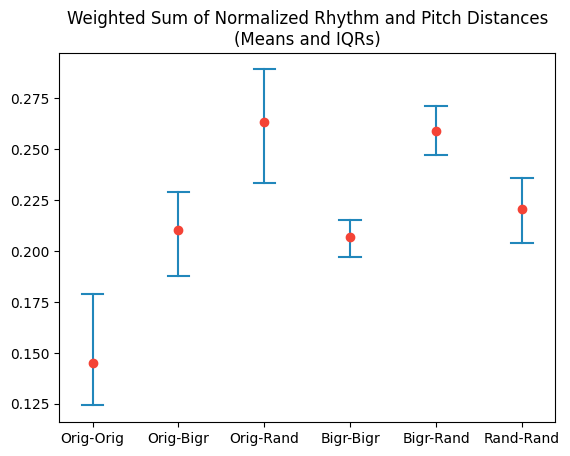

In [83]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt
import scipy.stats as st
import numpy as np

def strip_component(dict, component):
    strip_list = []
    if component == "pitch":
        part = 1
    if component == "rhythm":
        part = 0
    for i in dict.keys():
        strip_list.append(dict[i][part])
    return strip_list

def plot_confidence_interval(x, values, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
    stdev = np.std(values)
    confidence_interval = st.t.interval(alpha = 0.90, df=len(values)-1, loc=mean, scale=stdev)

    left = x - horizontal_line_width / 2
    top = p75 #max(confidence_interval)
    right = x + horizontal_line_width / 2
    bottom = p25 #min(confidence_interval)
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

#plt.xticks([1, 2, 3, 4, 5, 6], ['Orig-Orig', 'Orig-Bigr', 'Orig-Rand', 'Bigr-Bigr', 'Bigr-Rand', 'Rand-Rand'])
#plt.title('Chronotonic Rhythm Distance Confidence Interval')
#plot_confidence_interval(1, strip_component(orig_orig_mins, "rhythm"))
#plot_confidence_interval(2, strip_component(orig_bigr_mins, "rhythm"))
#plot_confidence_interval(3, strip_component(orig_rand_mins, "rhythm"))
#plot_confidence_interval(4, strip_component(bigr_bigr_mins, "rhythm"))
#plot_confidence_interval(5, strip_component(bigr_rand_mins, "rhythm"))
#plot_confidence_interval(6, strip_component(rand_rand_mins, "rhythm"))
#plt.show()



#plt.xticks([1, 2, 3, 4, 5, 6], ['Orig-Orig', 'Orig-Bigr', 'Orig-Rand', 'Bigr-Bigr', 'Bigr-Rand', 'Rand-Rand'])
#plt.title('Weighted Levenshtein Pitch Distance Confidence Interval')
#plot_confidence_interval(1, strip_component(orig_orig_mins, "pitch"))
#plot_confidence_interval(2, strip_component(orig_bigr_mins, "pitch"))
#plot_confidence_interval(3, strip_component(orig_rand_mins, "pitch"))
#plot_confidence_interval(4, strip_component(bigr_bigr_mins, "pitch"))
#plot_confidence_interval(5, strip_component(bigr_rand_mins, "pitch"))
#plot_confidence_interval(6, strip_component(rand_rand_mins, "pitch"))
#plt.show()

def combine_and_normalize(min_set, a=.5, b=.5):
    combined_normalized_min_set = []
    for min_pair in list(min_set.values()):
        weighted_sum_min = a*min_pair[0] + b*min_pair[1]
        #cobb_douglas_min = (min_pair[0]**a)*(min_pair[1]**b)
        #l2_min = np.sqrt(min_pair[0]**2 + min_pair[1]**2)
        #l1_min = min_pair[0] + min_pair[1]
        output = weighted_sum_min
        if output != 0:
            combined_normalized_min_set.append(output)
    return combined_normalized_min_set

orig_orig_combined_normalized_mins = combine_and_normalize(orig_orig_mins)
orig_bigr_combined_normalized_mins = combine_and_normalize(orig_bigr_mins)
orig_rand_combined_normalized_mins = combine_and_normalize(orig_rand_mins)
bigr_bigr_combined_normalized_mins = combine_and_normalize(bigr_bigr_mins)
bigr_rand_combined_normalized_mins = combine_and_normalize(bigr_rand_mins)
rand_rand_combined_normalized_mins = combine_and_normalize(rand_rand_mins)

plt.xticks([1, 2, 3, 4, 5, 6], ['Orig-Orig', 'Orig-Bigr', 'Orig-Rand', 'Bigr-Bigr', 'Bigr-Rand', 'Rand-Rand'])
plt.title('Weighted Sum of Normalized Rhythm and Pitch Distances\n(Means and IQRs)')
plot_confidence_interval(1, orig_orig_combined_normalized_mins)
plot_confidence_interval(2, orig_bigr_combined_normalized_mins)
plot_confidence_interval(3, orig_rand_combined_normalized_mins)
plot_confidence_interval(4, bigr_bigr_combined_normalized_mins)
plot_confidence_interval(5, bigr_rand_combined_normalized_mins)
plot_confidence_interval(6, rand_rand_combined_normalized_mins)
plt.show()

In [80]:
len(orig_orig_mins)

512

In [60]:
self_to_self_mins = merge(orig_orig_mins, bigr_bigr_mins, rand_rand_mins)

def cobb_douglas(min_set, a=.50, b=.50):
    combined_normalized_min_set = []
    for min_pair in list(min_set.values()):
        #min = a*min_pair[0] + b*min_pair[1]
        min = (min_pair[0]**a + min_pair[1]**a)**(1/a)
        #min = (min_pair[0]**a)*(min_pair[1]**b)
        output = min
        if output != 0:
            combined_normalized_min_set.append(output)
    return sum(combined_normalized_min_set) / len(combined_normalized_min_set)

for a in [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]:
    b = 1 - a
    print("With a = " + str(a) + ', we get ' + str(cobb_douglas(self_to_self_mins, a, b)))

#print(orig_orig_mins, bigr_bigr_mins, rand_rand_mins)

With a = 0.05, we get 161705.5632983547
With a = 0.1, we get 159.74405069717045
With a = 0.15, we get 16.034466043762347
With a = 0.2, we get 5.110499337055829
With a = 0.25, we get 2.585827212977284
With a = 0.3, we get 1.6485178038400317
With a = 0.35, we get 1.1992746284311346
With a = 0.4, we get 0.9474439436309318
With a = 0.45, we get 0.7907459678932233
With a = 0.5, we get 0.6857856919952359
With a = 0.55, we get 0.6115548998443425
With a = 0.6, we get 0.5568364653424067
With a = 0.65, we get 0.5151713405528918
With a = 0.7, we get 0.48261066275477826
With a = 0.75, we get 0.4566199480803894
With a = 0.8, we get 0.4355057933736072
With a = 0.85, we get 0.41809794789645893
With a = 0.9, we get 0.40356417422877383
With a = 0.95, we get 0.39129786039780573
With a = 1, we get 0.38084730928813887


In [79]:
import Levenshtein
Levenshtein.distance("FGAABBCC", "BGEBFGE")

6

In [ ]:
# Manual orig-orig, orig-bigr, orig-rand... initial pitch distances graph seems off
# Update - it's not off. It's just less precise than our rhythm bigrams. 

with open('levenshtein_costs/insert_costs.pkl', 'rb') as f:
    insert_costs = pickle.load(f)
with open('levenshtein_costs/delete_costs.pkl', 'rb') as f:
    delete_costs = pickle.load(f)
with open('levenshtein_costs/substitute_costs.pkl', 'rb') as f:
    substitute_costs = pickle.load(f)

min_oo = []
min_ob = []
min_or = []

for score_i in tqdm.tqdm(slangpolska_scores.keys()):

    min_normal_Lev_oo = 100
    min_normal_Lev_ob = 100
    min_normal_Lev_or = 100
    min_weighted_Lev_oo = 100
    min_weighted_Lev_ob = 100
    min_weighted_Lev_or = 100

    str1 = pitch_sequence(slangpolska_scores[score_i])
    for score_j in list(slangpolska_scores):
        str2 = pitch_sequence(slangpolska_scores[score_j])
        orig_orig_tmp = Levenshtein.distance(str1, str2)
        orig_orig_tmp2 = levenshtein(str1, len(str1), str2, len(str2), insert_costs, delete_costs, substitute_costs)
        if (orig_orig_tmp < min_normal_Lev_oo) and (score_i != score_j):
            min_normal_Lev_oo = orig_orig_tmp
            min_normal_Lev_oo_score = score_j
        if (orig_orig_tmp2 < min_weighted_Lev_oo) and (score_i != score_j):
            min_weighted_Lev_oo = orig_orig_tmp2
            min_weighted_Lev_oo_score = score_j
    l = -1
    for score_k in generated_from_random:
        l += 1
        str3 = pitch_sequence(score_k)
        orig_rand_tmp = Levenshtein.distance(str1, str3)
        orig_rand_tmp2 = levenshtein(str1, len(str1), str3, len(str3), insert_costs, delete_costs, substitute_costs)
        if orig_rand_tmp < min_normal_Lev_or:
            min_normal_Lev_or = orig_rand_tmp
            min_normal_Lev_or_score = str(l)
        if (orig_orig_tmp2 < min_weighted_Lev_or):
            min_weighted_Lev_or = orig_rand_tmp2
            min_weighted_Lev_or_score = str(l)

    n = -1
    for score_m in generated_from_bigrams:
        n += 1
        str4 = pitch_sequence(score_m)
        orig_bigr_tmp = Levenshtein.distance(str1, str4)
        orig_bigr_tmp2 = levenshtein(str1, len(str1), str4, len(str4), insert_costs, delete_costs, substitute_costs)
        if orig_bigr_tmp < min_normal_Lev_ob:
            min_normal_Lev_ob = orig_bigr_tmp
            min_normal_Lev_ob_score = str(n)
        if (orig_bigr_tmp2 < min_weighted_Lev_ob):
            min_weighted_Lev_ob = orig_bigr_tmp2
            min_weighted_Lev_ob_score = str(n)
    #print(score_i + "|| oo normal: " + str(min_normal_Lev_oo) + " from " + min_normal_Lev_oo_score + ", or normal: " + str(min_normal_Lev_or) + " from " + min_normal_Lev_or_score)
    #print(min_normal_Lev_oo, min_normal_Lev_ob, min_normal_Lev_or)
    #print(min_weighted_Lev_oo, min_weighted_Lev_ob, min_weighted_Lev_or)
    min_oo.append(min_weighted_Lev_oo)
    min_ob.append(min_weighted_Lev_ob)
    min_or.append(min_weighted_Lev_or)
    with open('manual_pitch_distances_oo.pkl', 'wb') as f:
        pickle.dump(min_oo, f)
    with open('manual_pitch_distances_ob.pkl', 'wb') as f:
        pickle.dump(min_ob, f)
    with open('manual_pitch_distances_or.pkl', 'wb') as f:
        pickle.dump(min_or, f)

def find_min_by_lefthand_score(set_to_set_distances):
    with open('all_distances/' + set_to_set_distances + '.pkl', 'rb') as f:
        distance_dict = pickle.load(f)
    distance_dict_mins_dict = {}
    for score in distance_dict.keys():
        distance_dict_mins_dict[score] = {}
        tmp_min = 100
        for comp in distance_dict[score].keys():
            if (distance_dict[score][comp] < tmp_min) and (score != comp):
                tmp_min = distance_dict[score][comp]
        distance_dict_mins_dict[score] = tmp_min
    return distance_dict_mins_dict

min_oo_pitch = find_min_by_lefthand_score("orig_to_orig_pitch_distances")
min_or_pitch = find_min_by_lefthand_score("orig_to_rand_pitch_distances")
min_ob_pitch = find_min_by_lefthand_score("orig_to_bigr_pitch_distances")
min_bb_pitch = find_min_by_lefthand_score("bigr_to_bigr_pitch_distances")
min_br_pitch = find_min_by_lefthand_score("bigr_to_rand_pitch_distances")
min_rr_pitch = find_min_by_lefthand_score("rand_to_rand_pitch_distances")

print(pd.Series(min_or_pitch.values()).describe())

def plot_confidence_interval(x, values, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    stdev = np.std(values)
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values,75)
    confidence_interval = st.t.interval(alpha = 0.95, df=len(values)-1, loc=mean, scale=stdev)

    left = x - horizontal_line_width / 2
    top = p75 #max(confidence_interval)
    right = x + horizontal_line_width / 2
    bottom = p25 #min(confidence_interval)
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

print(type(min_oo_pitch.values()))
plt.xticks([1, 2, 3, 4, 5, 6], ['Orig-Orig', 'Orig-Bigr', 'Orig-Rand', 'Bigr-Bigr', 'Bigr-Rand', 'Rand-Rand'])
plt.title('Weighted Levenshtein Pitch Distance Confidence Interval')
plot_confidence_interval(1, list(min_oo_pitch.values()))
plot_confidence_interval(2, list(min_ob_pitch.values()))
plot_confidence_interval(3, list(min_or_pitch.values()))
plot_confidence_interval(4, list(min_bb_pitch.values()))
plot_confidence_interval(5, list(min_br_pitch.values()))
plot_confidence_interval(6, list(min_rr_pitch.values()))
plt.show()


In [78]:
import Levenshtein
Levenshtein.distance("BGEBFGE", "FGAABBCC")
Levenshtein.editops("BGEBFGE", "FGAABBCC")

[('replace', 0, 0),
 ('insert', 2, 2),
 ('replace', 2, 3),
 ('replace', 4, 5),
 ('replace', 5, 6),
 ('replace', 6, 7)]

In [ ]:
# Chronotonic distance calculation. We actually use a function in helpers.py that produces effectively equivalent results (that one 
# interpolates piecewise functions with larger steps to save memory). 

import music21
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random

def chronotonic_comparison(stream_base_score_1, stream_base_score_2, subset_start = -1, show_graphs = False):
    final_measure_1 = stream_base_score_1.recurse().notesAndRests[-1].measureNumber
    final_measure_2 = stream_base_score_2.recurse().notesAndRests[-1].measureNumber
    final_measure_for_subset = final_measure_1
    if final_measure_2 < final_measure_for_subset:
        final_measure_for_subset = final_measure_2
    if (final_measure_for_subset < 8) or (final_measure_for_subset < (subset_start + 7)):
        print("ONE OF THE SCORES IS TOO SHORT")
        return "ONE OF THE SCORES IS TOO SHORT"
    if subset_start == -1:
        while True:
            subset_start = random.randint(1, (final_measure_for_subset - 8)+1)
            if subset_start%2 != 0:
                break
    else:
        # subset start passed in
        pass
    chrono1, xvals1, yvals1, xticks1, xlabs1 = chronotonic_builder(stream_base_score_1, subset_start, show_graphs)
    chrono2, xvals2, yvals2, xticks2, xlabs2 = chronotonic_builder(stream_base_score_2, subset_start, show_graphs)
    maxyvals = max(yvals1)
    if maxyvals < max(yvals2):
        maxyvals = max(yvals2)
    linspaced_subsets = pd.DataFrame(list(zip(xvals1, yvals1, xvals2, yvals2)), columns=['score1_xvals', 'score1_yvals', 'score2_xvals', 'score2_yvals'])
    linspaced_subsets['x_diff'] = linspaced_subsets['score1_xvals'] - linspaced_subsets['score2_xvals']
    linspaced_subsets['y_diff'] = abs(linspaced_subsets['score1_yvals'] - linspaced_subsets['score2_yvals'])
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(chrono1['onsets'], chrono1['heights'], width=chrono1['bin_widths'], align='edge', alpha = .3) # edgecolor='black'
        bar_plot = ax.bar(chrono2['onsets'], chrono2['heights'], width=chrono2['bin_widths'], align='edge', color='red', alpha = .3) # edgecolor='black'
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure # (Tick Indicates First Beat of Measure)")
        plt.title("Chronotonic sequence overlap (random 8-bar subset)")
        plt.plot(xvals1, yvals1, 'blue', alpha = 0.9)
        plt.plot(xvals2, yvals2, 'red', alpha = 0.9)
        plt.xticks(xticks1, xlabs1)
        plt.ylim([0,maxyvals+0.25])
        plt.show()
        plt.figure()
        plt.plot(linspaced_subsets['score1_xvals'],linspaced_subsets['y_diff'],color='black')
        maxdiff = max(linspaced_subsets['y_diff'])
        plt.xticks(xticks1, xlabs1)
        plt.ylim([0,maxdiff+0.25])
        plt.ylabel('Difference in Note Length')
        plt.xlabel('Measure # (Tick Indicates First Beat of Measure)')
        x_axis = np.linspace(xticks1[0], xticks1[-1], 10000, endpoint=True)
        plt.fill_between(x_axis, linspaced_subsets['y_diff'], color='black', alpha = .3)
        plt.title("Absolute Difference in Chronotonic Sequence")
        plt.show()
    #print(pd.DataFrame(list(zip(chrono1['onsets'],chrono2['onsets'])),columns=('chrono1_onsets','chrono2_onsets')))
    return np.trapz(linspaced_subsets['y_diff'], linspaced_subsets['score1_xvals'])
    #return linspaced_subsets
    
def chronotonic_builder(stream_base_score, subset_start=1, show_graphs = False):
    onsets = []
    heights = []
    final_measure = stream_base_score.recurse().notesAndRests[-1].measureNumber
    for n_or_r in stream_base_score.recurse().notesAndRests:
        #print(n_or_r, n_or_r.beat + (3 * (n_or_r.measureNumber-1)), n_or_r.duration.quarterLength)
        onsets.append(n_or_r.beat + (3 * (n_or_r.measureNumber-1)))
        if isinstance(n_or_r, (music21.note.Note,music21.chord.Chord)):
            heights.append(n_or_r.duration.quarterLength)
        else:
            heights.append(float(0))
    x = np.asarray(onsets)
    y = np.asarray(heights)
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(x, y, width=y, align='edge', edgecolor='black') # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        x_tick_locs = np.arange(1, final_measure*3, 3).tolist()
        x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        #print(x_tick_locs, x_tick_labels)
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Full chronotonic sequence")
        plt.show()

    # Now display a random subset
    chronotonic_start = subset_start
    chronotonic_end = chronotonic_start + 8
    filter_arr_start = (x >= (3*(chronotonic_start-1))+1)

    chrono_sequence = pd.DataFrame(list(zip(filter_arr_start.tolist(), x.tolist(), y.tolist())), columns=['filter_start','onsets','heights'])
    chrono_sequence = chrono_sequence[chrono_sequence['onsets'] < ((3*(chronotonic_end-1))+1)]
    first_index = chrono_sequence.index[chrono_sequence['filter_start'] == True].tolist()[0]
    if first_index != 0:
        chrono_sequence = chrono_sequence[first_index-1:]
        #print(first_index, chrono_sequence)
        if int(chrono_sequence['onsets'].tolist()[1]) == int((3*(chronotonic_start-1))+1):
            chrono_sequence = chrono_sequence[1:]
        else:
            chrono_sequence.at[0,'onsets'] = (3*(chronotonic_start-1))+1
    else:
        chrono_sequence = chrono_sequence[first_index:]
    chrono_sequence['bin_widths'] = chrono_sequence.diff(periods=-1)['onsets']*-1
    chrono_sequence.at[chrono_sequence.iloc[-1].name,'bin_widths'] = ((3*(chronotonic_end-1))+1) - chrono_sequence['onsets'].tolist()[-1]
    
    # Pulled out of if statement so they can be passed to comparison graph
    x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
    x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(chrono_sequence['onsets'], chrono_sequence['heights'], width=chrono_sequence['bin_widths'], align='edge', edgecolor='black', alpha = .5) # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        #x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
        #x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Chronotonic sequence subset")

    # Add interpolated version, to be used in difference calculations
    onsets_list = chrono_sequence['onsets'].tolist()
    heights_list = chrono_sequence['heights'].tolist()
    x_for_interp = []
    y_for_interp = []
    for i,x in enumerate(onsets_list):
        if i != 0:
            x_for_interp.append(float(onsets_list[i-1]))
            y_for_interp.append(float(heights_list[i-1]))
            x_for_interp.append(float(onsets_list[i]-.000001))
            y_for_interp.append(float(heights_list[i-1]))
    x_for_interp.append(float(onsets_list[-1]))
    y_for_interp.append(float(heights_list[-1]))
    xvals = np.linspace((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+1, 10000)
    yinterp = np.interp(xvals, x_for_interp, y_for_interp)
    if show_graphs == True:
        plt.plot(xvals, yinterp, 'blue')
        plt.show()
    return chrono_sequence, xvals, yinterp, x_tick_locs, x_tick_labels

In [ ]:
# EXAMPLE CHRONOTONIC SEQUENCE AND DISTANCES
# Now, a function that passes in a score name to create the above graphs
# chronotonic_builder(slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], show_graphs=True)
chronotonic_comparison(slangpolska_scores['Pollonesse_183254_460e7c.xml'], slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], subset_start = 1, show_graphs=True)

In [ ]:
# Sense checks for distance function
# first must be 0
# second and third might differ without subset_start argument, that's due to randomness in 8 bars selected for comparison.
print(chronotonic_comparison(slangpolska_scores['Pollonesse_183254_460e7c.xml'], slangpolska_scores['Pollonesse_183254_460e7c.xml'],show_graphs=False))
print(chronotonic_comparison(slangpolska_scores['Pollonesse_183254_460e7c.xml'], slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], subset_start = 1, show_graphs=False))
print(chronotonic_comparison(slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], slangpolska_scores['Pollonesse_183254_460e7c.xml'], subset_start = 1, show_graphs=False))

In [ ]:
# Example for paper - three bars of Dahl_polska_efter_Ola_Olsson_bf94a6.xml

chrono1, xvals1, yvals1, xticks1, xlabs1 = chronotonic_builder(slangpolska_scores['Dahl_polska_efter_Ola_Olsson_bf94a6.xml'], subset_start = 1, show_graphs=False)
#chrono_sequence
fig, ax = plt.subplots()
xvals_6bars = chrono1['onsets'][chrono1['onsets'] < 16]
yvals_6bars = chrono1['heights'][chrono1['onsets'] < 16]
binw_6bars = chrono1['bin_widths'][chrono1['onsets'] < 16]
xvals_3bars = xvals_6bars.loc[xvals_6bars.loc[lambda x : x >= 10].index.values.tolist()]
yvals_3bars = yvals_6bars.loc[xvals_6bars.loc[lambda x : x >= 10].index.values.tolist()]
binw_3bars = binw_6bars.loc[xvals_6bars.loc[lambda x : x >= 10].index.values.tolist()]

bar_plot = ax.bar(xvals_3bars, yvals_3bars, width=binw_3bars, align='edge', edgecolor='black', alpha = .5) # width=bin_width
ax.set_xlabel("Measure.Beat", fontsize=12)
plt.xticks([10,11,12,13,14,15,16], ['4.1','4.2','4.3','5.1','5.2','5.3','6.1'], fontsize=10)
xvals = np.array(xvals1)
tmp_indices = np.where(np.logical_and(xvals > 10,xvals < 16), True, False)
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(xvals[tmp_indices], yvals1[tmp_indices], 'blue')
ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [8,8]
ax.get_yaxis().set_visible(False)
plt.show()

chrono2, xvals2, yvals2, xticks2, xlabs2 = chronotonic_builder(slangpolska_scores['_1814_698087.xml'], subset_start = 1, show_graphs=False)

maxyvals = max(yvals1)
if maxyvals < max(yvals2):
    maxyvals = max(yvals2)
linspaced_subsets = pd.DataFrame(list(zip(xvals1, yvals1, xvals2, yvals2)), columns=['score1_xvals', 'score1_yvals', 'score2_xvals', 'score2_yvals'])
linspaced_subsets['x_diff'] = linspaced_subsets['score1_xvals'] - linspaced_subsets['score2_xvals']
linspaced_subsets['y_diff'] = abs(linspaced_subsets['score1_yvals'] - linspaced_subsets['score2_yvals'])

fig, ax = plt.subplots()

xvals2_6bars = chrono2['onsets'][chrono2['onsets'] < 16]
yvals2_6bars = chrono2['heights'][chrono2['onsets'] < 16]
binw2_6bars = chrono2['bin_widths'][chrono2['onsets'] < 16]
xvals2_3bars = xvals2_6bars.loc[xvals2_6bars.loc[lambda x : x >= 10].index.values.tolist()]
yvals2_3bars = yvals2_6bars.loc[xvals2_6bars.loc[lambda x : x >= 10].index.values.tolist()]
binw2_3bars = binw2_6bars.loc[xvals2_6bars.loc[lambda x : x >= 10].index.values.tolist()]

bar_plot = ax.bar(xvals_3bars, yvals_3bars, width=binw_3bars, align='edge', edgecolor='black', alpha = .5) # edgecolor='black'
bar_plot = ax.bar(xvals2_3bars, yvals2_3bars, width=binw2_3bars, align='edge', color='red', edgecolor='black', alpha = .5) # edgecolor='black'
#ax.set_ylabel("Note Length")
#ax.set_xlabel("Measure # (Tick Indicates First Beat of Measure)")
#plt.title("Chronotonic sequence overlap (random 8-bar subset)")
plt.plot(xvals[tmp_indices], yvals1[tmp_indices], alpha = 1)
plt.plot(xvals[tmp_indices], yvals2[tmp_indices], 'red', alpha = 1)
plt.xticks([10,11,12,13,14,15,16], ['4.1','4.2','4.3','5.1','5.2','5.3','6.1'])
plt.ylim([0,1.25])
ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [8,8]
ax.get_yaxis().set_visible(False)
plt.xlabel("Measure.Beat", fontsize=12)
#plt.show()

fig, ax = plt.subplots()
tmp_indices = np.where(np.logical_and(linspaced_subsets['score1_xvals'] > 10,linspaced_subsets['score1_xvals'] < 16), True, False)
linsubs_xvals_3bars = linspaced_subsets['score1_xvals'].loc[tmp_indices]
linsubs_yvals_3bars = linspaced_subsets['y_diff'].loc[tmp_indices]

plt.plot(linsubs_xvals_3bars,linsubs_yvals_3bars,color='black')
plt.xticks([10,11,12,13,14,15,16], ['4.1','4.2','4.3','5.1','5.2','5.3','6.1'])
plt.ylim([0,1])
plt.fill_between(linsubs_xvals_3bars, linsubs_yvals_3bars, color='black', alpha = .3)
ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [4,4]
ax.get_yaxis().set_visible(False)
plt.xlabel("Measure.Beat", fontsize=12)
plt.show(5)

np.trapz(linsubs_yvals_3bars, linsubs_xvals_3bars)


In [ ]:
# recover and modify graphs in original chronotonic distance func for use in paper
# work is done here - rest is for paper

# Chronotonic distance calculation. We actually use a function further down in the script that produces effectively equivalent results (later function 
# interpolates piecewise functions with larger steps to save memory). 

import music21
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random

def chronotonic_comparison_paper(stream_base_score_1, stream_base_score_2, subset_start = -1, show_graphs = False):
    final_measure_1 = stream_base_score_1.recurse().notesAndRests[-1].measureNumber
    final_measure_2 = stream_base_score_2.recurse().notesAndRests[-1].measureNumber
    final_measure_for_subset = final_measure_1
    if final_measure_2 < final_measure_for_subset:
        final_measure_for_subset = final_measure_2
    if (final_measure_for_subset < 8) or (final_measure_for_subset < (subset_start + 7)):
        print("ONE OF THE SCORES IS TOO SHORT")
        return "ONE OF THE SCORES IS TOO SHORT"
    if subset_start == -1:
        while True:
            subset_start = random.randint(1, (final_measure_for_subset - 8)+1)
            if subset_start%2 != 0:
                break
    else:
        # subset start passed in
        pass
    chrono1, xvals1, yvals1, xticks1, xlabs1 = chronotonic_builder_paper(stream_base_score_1, subset_start, show_graphs)
    chrono2, xvals2, yvals2, xticks2, xlabs2 = chronotonic_builder_paper(stream_base_score_2, subset_start, show_graphs)
    maxyvals = max(yvals1)
    if maxyvals < max(yvals2):
        maxyvals = max(yvals2)

    fig, ax = plt.subplots()
    bar_plot = ax.bar(chrono1['onsets'], chrono1['heights'], width=chrono1['bin_widths'], align='edge', alpha = .3) # edgecolor='black'
    bar_plot = ax.bar(chrono2['onsets'], chrono2['heights'], width=chrono2['bin_widths'], align='edge', color='red', alpha = .3) # edgecolor='black'
    ax.set_ylabel("Note Length")
    ax.set_xlabel("Measure # (Tick Indicates First Beat of Measure)", fontsize=12)
    plt.title("Chronotonic sequence overlap (random 8-bar subset)")
    plt.plot(xvals1, yvals1, 'blue', alpha = 0.9)
    plt.plot(xvals2, yvals2, 'red', alpha = 0.9)
    plt.xticks(xticks1, xlabs1)
    ax.set_aspect('equal')
    plt.rcParams['figure.figsize'] = [8,8]
    ax.get_yaxis().set_visible(False)
    if maxyvals < 1:
        plt.ylim([0,maxyvals+2])
    plt.show()
    
def chronotonic_builder_paper(stream_base_score, subset_start=1, show_graphs = False):
    onsets = []
    heights = []
    final_measure = stream_base_score.recurse().notesAndRests[-1].measureNumber
    for n_or_r in stream_base_score.recurse().notesAndRests:
        #print(n_or_r, n_or_r.beat + (3 * (n_or_r.measureNumber-1)), n_or_r.duration.quarterLength)
        onsets.append(n_or_r.beat + (3 * (n_or_r.measureNumber-1)))
        if isinstance(n_or_r, (music21.note.Note,music21.chord.Chord)):
            heights.append(n_or_r.duration.quarterLength)
        else:
            heights.append(float(0))
    x = np.asarray(onsets)
    y = np.asarray(heights)
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(x, y, width=y, align='edge', edgecolor='black') # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        x_tick_locs = np.arange(1, final_measure*3, 3).tolist()
        x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        #print(x_tick_locs, x_tick_labels)
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Full chronotonic sequence")
        #plt.show()

    # Now display a random subset
    chronotonic_start = subset_start
    chronotonic_end = chronotonic_start + 8
    filter_arr_start = (x >= (3*(chronotonic_start-1))+1)

    chrono_sequence = pd.DataFrame(list(zip(filter_arr_start.tolist(), x.tolist(), y.tolist())), columns=['filter_start','onsets','heights'])
    chrono_sequence = chrono_sequence[chrono_sequence['onsets'] < ((3*(chronotonic_end-1))+1)]
    first_index = chrono_sequence.index[chrono_sequence['filter_start'] == True].tolist()[0]
    if first_index != 0:
        chrono_sequence = chrono_sequence[first_index-1:]
        #print(first_index, chrono_sequence)
        if int(chrono_sequence['onsets'].tolist()[1]) == int((3*(chronotonic_start-1))+1):
            chrono_sequence = chrono_sequence[1:]
        else:
            chrono_sequence.at[0,'onsets'] = (3*(chronotonic_start-1))+1
    else:
        chrono_sequence = chrono_sequence[first_index:]
    chrono_sequence['bin_widths'] = chrono_sequence.diff(periods=-1)['onsets']*-1
    chrono_sequence.at[chrono_sequence.iloc[-1].name,'bin_widths'] = ((3*(chronotonic_end-1))+1) - chrono_sequence['onsets'].tolist()[-1]
    
    # Pulled out of if statement so they can be passed to comparison graph
    x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
    x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(chrono_sequence['onsets'], chrono_sequence['heights'], width=chrono_sequence['bin_widths'], align='edge', edgecolor='black', alpha = .5) # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        #x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
        #x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Chronotonic sequence subset")

    # Add interpolated version, to be used in difference calculations
    onsets_list = chrono_sequence['onsets'].tolist()
    heights_list = chrono_sequence['heights'].tolist()
    x_for_interp = []
    y_for_interp = []
    for i,x in enumerate(onsets_list):
        if i != 0:
            x_for_interp.append(float(onsets_list[i-1]))
            y_for_interp.append(float(heights_list[i-1]))
            x_for_interp.append(float(onsets_list[i]-.000001))
            y_for_interp.append(float(heights_list[i-1]))
    x_for_interp.append(float(onsets_list[-1]))
    y_for_interp.append(float(heights_list[-1]))
    xvals = np.linspace((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+1, 10000)
    yinterp = np.interp(xvals, x_for_interp, y_for_interp)
    if show_graphs == True:
        plt.plot(xvals, yinterp, 'blue')
        #plt.show()
    return chrono_sequence, xvals, yinterp, x_tick_locs, x_tick_labels

#Example bad generated score
#chronotonic_comparison_paper(slangpolska_scores['Ninas_slängpolska_316123.xml'], generated_from_bigrams[35], subset_start = 1, show_graphs=True)
#Example good generated score
#chronotonic_comparison_paper(slangpolska_scores['Polonäs_9ddddb.xml'], generated_from_bigrams[243], subset_start = 1, show_graphs=True)

# To display bad/good examples (first two bad second two good)
#slangpolska_scores['Ninas_slängpolska_316123.xml'].show()
#generated_from_bigrams[35].show()
#slangpolska_scores['Polonäs_9ddddb.xml'].show()
#generated_from_bigrams[243].show()
